In [3]:
#Modelos
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

#Medidas de validação
from sklearn.metrics import accuracy_score,recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

#Tratamento e Visualização de Dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Filtrar avisos desnecessários
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("../Dados/Base de dados Tratada.csv")
df.head()

,Unnamed: 0,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Vamos agora preparar os nosso dados!

-Remover a coluna 	Unnamed: 0 que foi criada e a coluna de complain pois ela está 100% relacionada aos dados de cancelamento dos clientes;

-Transformar as colunas categoricas em numericas, pelas tecnicas: One-Hot Encoding(Geography e Gender) e por Mapeamento de Categorias(Card Type);

-Separar a base de dados em treino e teste;

Depois disso vamos implementar nossos algoritimos de machine learning, validar os mesmos e analisar o que se saiu melhor! Como as classes estão desbalanceadas, vou ter que analisar não só a acuracia mas outras metricas como o recall, Curva ROC... Então, irei testar os modelos de machine learning com funçoes especificas para determinados modelos!

In [5]:
df = df.drop("Unnamed: 0", axis=1)#Restirando a coluna desnecessária

In [6]:
dfTratado = pd.get_dummies(df, columns=["Geography", "Gender"])#Trangormando as colunas categoricas em dammies(valores de 0 e 1 para cada categoria)
dfTratado

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,771,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300,True,False,False,False,True
9564,516,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771,True,False,False,False,True
9565,709,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564,True,False,False,True,False
9566,772,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339,False,True,False,False,True


In [7]:
mapeamento = {'DIAMOND': 3, 'GOLD': 2, 'SILVER': 0, 'PLATINUM': 1}
dfTratado["Card Type"] = dfTratado['Card Type'].map(mapeamento)#Transformando os valores dos cartões em valores numericos com base na sua relevancia(0 à 3)
dfTratado

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,3,464,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,3,456,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,3,377,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,2,350,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,2,425,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,771,39,5,0.00,2,1,0,96270.64,0,0,1,3,300,True,False,False,False,True
9564,516,35,10,57369.61,1,1,1,101699.77,0,0,5,1,771,True,False,False,False,True
9565,709,36,7,0.00,1,0,1,42085.58,1,1,3,0,564,True,False,False,True,False
9566,772,42,3,75075.31,2,1,0,92888.52,1,1,2,2,339,False,True,False,False,True


Após a tranformação dos dados categoricos em númericos, podemos separar nossa base de dados em treino e teste para implementarmos nosso modelos de machine learning e ver qual se sai melhor!

In [8]:
X = dfTratado.drop(["Exited", "Complain"], axis=1) 
y = dfTratado["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Separção de treino e teste feita, vamos agora partir para a implmentação dos modelos e ver qual terá o melhor resultado! Lembrando que a base de dados, a coluna principal(target) está desbalanceada, então vamos ultilizar outras medidas além da acuracia para determinarmos quem será o melhor.

In [9]:

def predicaoModelosArvores(modelo, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    model = modelo(random_state=42, class_weight='balanced',max_depth=10)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print(acuracia, rc)

predicaoModelosArvores(DecisionTreeClassifier, X_train, y_train)
predicaoModelosArvores(RandomForestClassifier, X_train, y_train)
predicaoModelosArvores(BalancedRandomForestClassifier, X_train, y_train)


0.7472240365774004 0.6765676567656765
0.8484650555192684 0.5775577557755776
0.6701502286087524 0.8415841584158416


In [10]:
def predicaoModelosGBboost(modelo, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    class_counts = y_train.value_counts()
    negativos = class_counts[0]
    positivos = class_counts[1]
    scale_pos_weight = negativos/positivos #servi para o modelo dar um foco maior na classe com menor numeros de dados na target

    model = modelo(scale_pos_weight=scale_pos_weight, learning_rate=0.1, random_state=42)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(acuracia, rc, f1)

predicaoModelosGBboost(XGBClassifier,  X_train, y_train)

0.8288700195950359 0.7029702970297029 0.6191860465116279


In [11]:
def predicaoModelosLogistico(modelo, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = modelo(class_weight='balanced', max_iter=1000, solver='lbfgs')
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    acuracia = accuracy_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print(acuracia, rc)

predicaoModelosLogistico(LogisticRegression,  X_train, y_train)

0.7354670150228608 0.7062706270627063


Após a analise dos resultados, vemos que o que se saiu melhor foi o XGBClassifier, agora vamos encontrar os melhores parametros e validar nosso modelo! Para testar os parametros, eu irei ultilizar o RandomSearchCV já que o GridSearchCV tem um custo computacional muito grande, e aqui eu estou testando muitas hiperparametros.

In [12]:
from scipy.stats import uniform, randint
parametros = {
    'max_depth': randint(3, 5),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [3.9364102564102565],  # Ajuste para desbalanceamento
}

model = XGBClassifier(random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)

randomSearch = RandomizedSearchCV(
    estimator=model,
    param_distributions=parametros,
    n_iter=50,  
    scoring='recall',  
    cv=cv,  # Número de folds na validação cruzada
    verbose=1,  # Mostra logs durante o treinamento
    n_jobs=-1,  # Usa todos os cores disponíveis
    random_state=42
)


randomSearch.fit(X_train, y_train)
resultados = pd.DataFrame(randomSearch.cv_results_)
dfd = resultados.sort_values(by="mean_test_score", ascending=False)
dfd.head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.178394,0.003869,0.015675,0.002886,0.655008,0.11232,3,2,3.93641,0.969877,"{'colsample_bytree': 0.6550083776583973, 'lear...",0.778878,0.696370,0.739274,0.729373,0.735099,0.735799,0.026322,1
47,0.187377,0.009746,0.014458,0.004395,0.603679,0.040441,3,9,3.93641,0.602025,"{'colsample_bytree': 0.6036788206466518, 'lear...",0.778878,0.706271,0.742574,0.732673,0.718543,0.735788,0.024824,2
5,0.326251,0.035704,0.025204,0.009715,0.759944,0.024,4,3,3.93641,0.752985,"{'colsample_bytree': 0.7599443886861021, 'lear...",0.795380,0.693069,0.735974,0.739274,0.715232,0.735786,0.034090,3
1,0.237509,0.023457,0.019561,0.006705,0.662407,0.056798,3,8,3.93641,0.733483,"{'colsample_bytree': 0.6624074561769746, 'lear...",0.778878,0.706271,0.749175,0.732673,0.711921,0.735783,0.026407,4
36,0.179991,0.005074,0.017518,0.005146,0.904648,0.081291,3,6,3.93641,0.747113,"{'colsample_bytree': 0.9046478461314871, 'lear...",0.772277,0.702970,0.745875,0.716172,0.735099,0.734479,0.024029,5


Depois de ajustarmos os hiper parametros, vamos validar nosso modoelo!

In [13]:
estimadorFinal = randomSearch.best_estimator_
scoresAccuracy = cross_val_score(estimadorFinal, X_train, y_train, cv=cv, scoring='accuracy')
scoresRecall = cross_val_score(estimadorFinal, X_train, y_train, cv=cv, scoring='recall')

# Resultados
print(f"Acurácia em cada fold: Acuracia =  {scoresAccuracy}")
print(f"Acurácia em cada fold: recall =  {scoresRecall}")
      
print("Acurácia média:", scoresAccuracy.mean())
print("Recall medio: ", scoresRecall.mean())

Acurácia em cada fold: Acuracia =  [0.80862182 0.80796865 0.80535598 0.78772044 0.81111111]
Acurácia em cada fold: recall =  [0.78217822 0.69636964 0.73267327 0.71947195 0.73509934]
Acurácia média: 0.8041555991000798
Recall medio:  0.733158481411055


Agora vamos analisar a curva Roc e a matris de confusão!

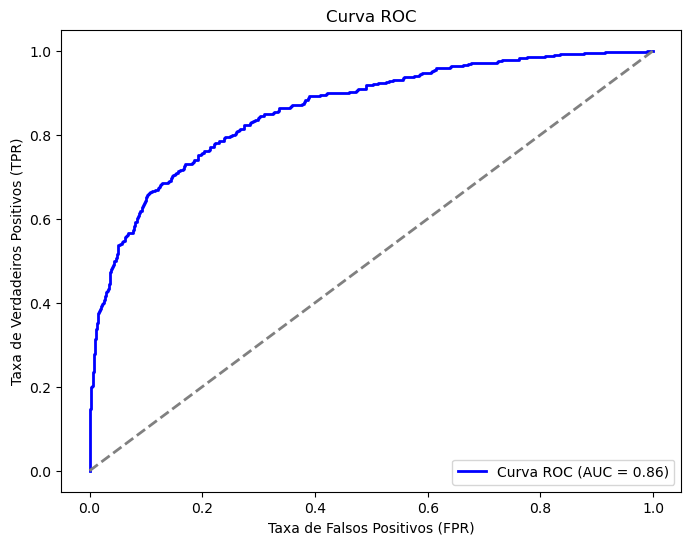

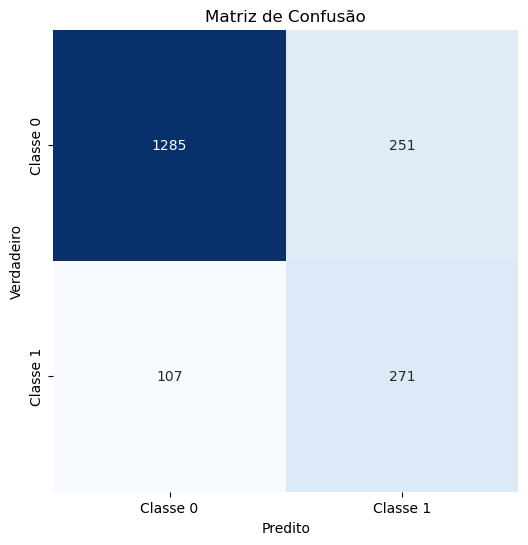

In [14]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

#Prever probabilidades para a curva ROC
y_pred_prob = estimadorFinal.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

#Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

#Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

#Calcular a matriz de confusão
y_pred = estimadorFinal.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# 8. Plotar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

O modelo alcançou um recall de 73%, o que significa que ele conseguiu identificar corretamente 73%% dos verdadeiros positivos. Esse é um resultado bastante positivo, especialmente considerando que o conjunto de dados é desbalanceado. Um recall alto é importante em problemas onde a classe positiva (minoritária) é crítica, como em diagnósticos médicos ou detecção de fraudes, pois garante que a maioria dos casos relevantes seja capturada.

Além disso, a curva ROC mostrou uma área sob a curva (AUC) de 0.86, indicando que o modelo tem uma boa capacidade de distinguir entre as classes positiva e negativa. A curva se afasta significativamente da linha de base (a diagonal), confirmando que o modelo performa muito melhor do que um classificador aleatório.

No entanto, o F1-Score de 60.1 sugere que há um trade-off entre precisão e recall. Isso ocorre porque, embora o modelo capture a maioria dos verdadeiros positivos, ele também classifica uma quantidade considerável de falsos positivos. Esse comportamento é comum em problemas desbalanceados, onde o modelo tende a priorizar a classe majoritária.

Em resumo, o modelo já apresenta um desempenho sólido, com um recall e uma AUC destacáveis. Agora por ultimo, vamos analisar quais são as variavies que tem maior influencia na hhora da decisão do nosso modelo!

Text(0.5, 1.0, 'Importância das Variáveis no Modelo (Cores por Influência)')

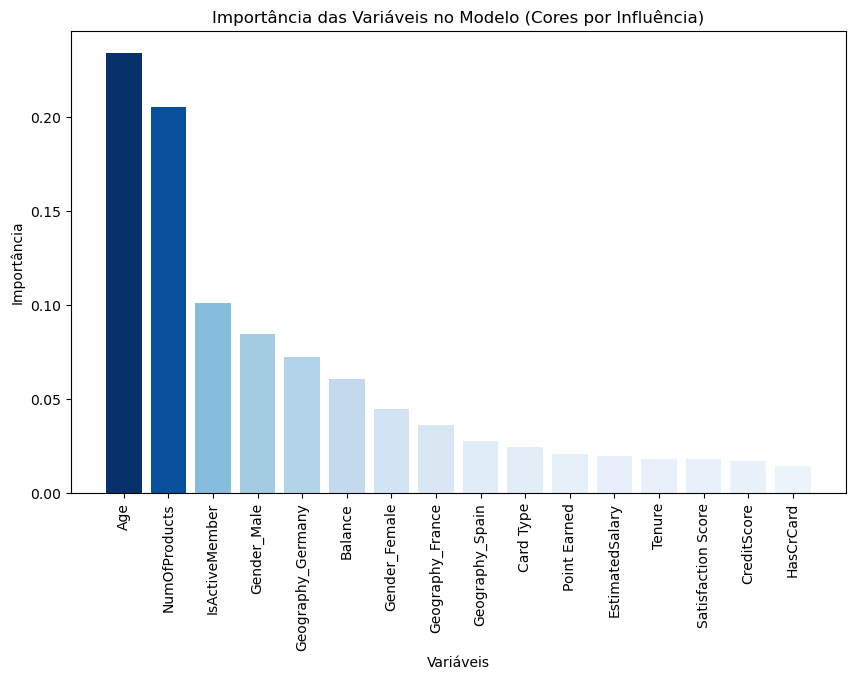

In [15]:
#Criando uma base de dados com os valores de influencia por coluna
colunasQueInfluenciamNaDecisão = {
    "Colunas" : X_train.columns,
    "Influencia" : estimadorFinal.feature_importances_
}
colunasQueInfluenciamNaDecisão = pd.DataFrame(colunasQueInfluenciamNaDecisão)
ordenadoPorColunasQueInfluenciamNaDecisão = colunasQueInfluenciamNaDecisão.sort_values(by = "Influencia", ascending=False)


influencias = ordenadoPorColunasQueInfluenciamNaDecisão["Influencia"] / ordenadoPorColunasQueInfluenciamNaDecisão["Influencia"].max()

# Criar um gradiente de cores (quanto maior a importância, mais escura a barra)
colors = plt.cm.Blues(influencias)  # Usando o colormap 'Blues'

# Plotar o gráfico de barras com cores baseadas na importância
plt.figure(figsize=(10, 6))
bars = plt.bar(ordenadoPorColunasQueInfluenciamNaDecisão["Colunas"], ordenadoPorColunasQueInfluenciamNaDecisão["Influencia"] , color=colors)
plt.xticks(range(len(ordenadoPorColunasQueInfluenciamNaDecisão["Colunas"])), ordenadoPorColunasQueInfluenciamNaDecisão["Colunas"].values, rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.title('Importância das Variáveis no Modelo (Cores por Influência)')


### **Idade, Status de Cliente Ativo e Número de Produtos: Impacto no Churn**

A análise dos dados revelou que a **idade**, o **status de cliente ativo** e o **número de produtos** são fatores-chave para o churn de cartão de crédito. Clientes mais velhos têm uma **maior tendência a cancelar** o cartão, possivelmente devido a mudanças nas necessidades financeiras ou à transição para a aposentadoria. Além disso, clientes que **não são ativos** (ou seja, que utilizam pouco o cartão) têm uma **probabilidade significativamente maior de cancelar**. Isso sugere que a falta de engajamento com o produto é um dos principais motivos para o churn.

Outro insight importante é a relação **inversamente proporcional** entre o **número de produtos** e o churn. Clientes com **mais produtos contratados** (como empréstimos, seguros ou investimentos) tendem a **cancelar menos** o cartão de crédito. Isso indica que a **diversificação de serviços** pode aumentar a retenção de clientes.

Esses insights destacam a importância de **estratégias direcionadas**, como programas de fidelidade para clientes mais velhos, incentivos ao uso do cartão para aumentar o engajamento e ofertas de produtos adicionais para fortalecer o relacionamento com o cliente. Ao focar nessas áreas, a empresa pode reduzir o churn e melhorar a retenção de clientes.